<a href="https://colab.research.google.com/github/jephta96/Optimisation-of-Digital-Modulation-Techniques/blob/main/AnnClassifierForModulationClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle
import os,random, sys
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.fftpack import dct
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time


In [2]:
# Load the RML2016 dataset using the correct file path
with open('/content/drive/MyDrive/RML2016.10a_dict.pkl', 'rb') as file:
    dataset = pickle.load(file, encoding='latin1')

    print(dataset.keys())


digital_dataset = {}

for key, value in dataset.items():
    modulation = key[0]
    if modulation in ['QPSK', '8PSK', 'QAM16', 'GFSK', 'CPFSK','PAM4','BPSK','QAM64']:
        digital_dataset[key] = value

# Apply DCT to each signal in the dataset
dct_dataset = {}

dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4

In [3]:
for key, value in digital_dataset.items():
    # Apply DCT to each signal in the dataset
    transformed_value = dct(value)

    # Store the transformed value in the new dictionary
    dct_dataset[key] = transformed_value


Xd = dct_dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)


# Partition the data into training and test sets
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)
train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))
X_train = X[train_idx]
X_test = X[test_idx]


def onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1


Y_train = onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
classes = mods
print(X_test.shape)
print(in_shp)


(32000, 2, 128)
[2, 128]


In [ ]:
# Create the ANN model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=in_shp))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

learning_rate = 0.002

optimizer = Adam(learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

filepath = 'best_weights.wts.h5'

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time_ann = time.time()

history = model.fit(X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_test, Y_test), verbose=2, callbacks=[ reduce_lr,
                    ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'), early_stopping])

end_time_ann = time.time()

training_time_ann = end_time_ann - start_time_ann


model.load_weights(filepath)


# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2, 512)            66048     
                                                                 
 batch_normalization (Batch  (None, 2, 512)            2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2, 512)            0         
                                                                 
 dense_1 (Dense)             (None, 2, 256)            131328    
                                                                 
 batch_normalization_1 (Bat  (None, 2, 256)            1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 2, 256)            0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1280/1280 - 6s - loss: 1.5887 - accuracy: 0.3477 - val_loss: 1.4688 - val_accuracy: 0.3824 - lr: 0.0020 - 6s/epoch - 5ms/step
Epoch 3/100
1280/1280 - 7s - loss: 1.5530 - accuracy: 0.3581 - val_loss: 1.4534 - val_accuracy: 0.3832 - lr: 0.0020 - 7s/epoch - 5ms/step
Epoch 4/100
1280/1280 - 7s - loss: 1.5288 - accuracy: 0.3665 - val_loss: 1.4386 - val_accuracy: 0.3965 - lr: 0.0020 - 7s/epoch - 5ms/step
Epoch 5/100
1280/1280 - 7s - loss: 1.5098 - accuracy: 0.3746 - val_loss: 1.4173 - val_accuracy: 0.4058 - lr: 0.0020 - 7s/epoch - 5ms/step
Epoch 6/100
1280/1280 - 7s - loss: 1.4893 - accuracy: 0.3840 - val_loss: 1.3962 - val_accuracy: 0.4135 - lr: 0.0020 - 7s/epoch - 5ms/step
Epoch 7/100
1280/1280 - 7s - loss: 1.4707 - accuracy: 0.3922 - val_loss: 1.3766 - val_accuracy: 0.4242 - lr: 0.0020 - 7s/epoch - 5ms/step
Epoch 8/100
1280/1280 - 6s - loss: 1.4528 - accuracy: 0.3987 - val_loss: 1.3593 - val_accuracy: 0.4346 - lr: 0.0020 - 6s/epoch - 5ms/step
Epoch 9/100
1280/1280 - 7s - loss: 1.4342 - ac

ANN Classifier Training Time: 421.86 seconds


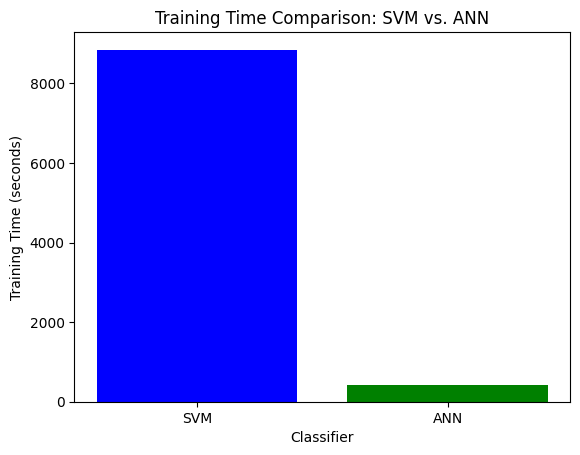

In [ ]:
print("ANN Classifier Training Time: {:.2f} seconds".format(training_time_ann))

training_time_svm = 8843.29

classifiers = ['SVM', 'ANN']
training_times = [training_time_svm, training_time_ann]

plt.bar(classifiers, training_times, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison: SVM vs. ANN')
plt.show()

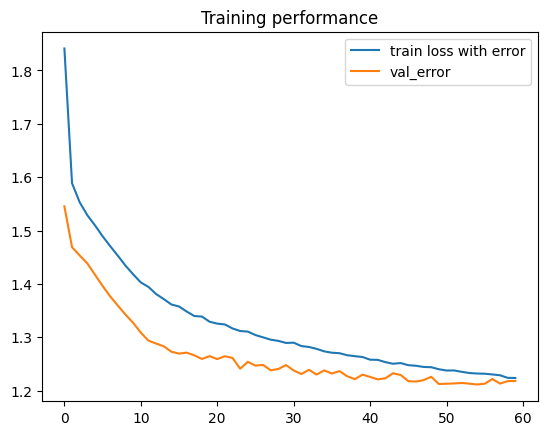

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss with error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


320/320 [==============================] - 1s 2ms/step
prediction time: 1.370185375213623


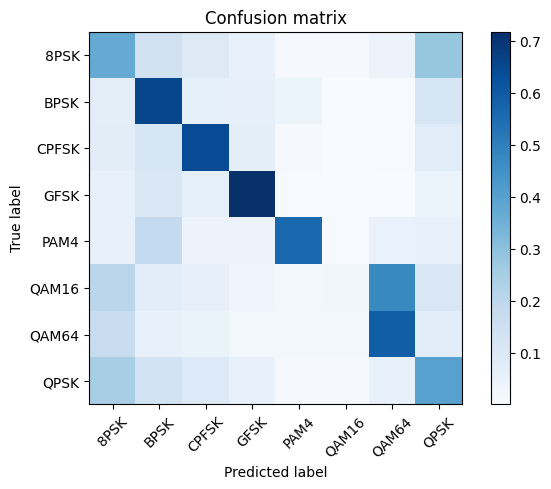

In [ ]:
start_ann_runtime = time.time()

# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=100)

end_ann_runtime = time.time()

pred_time_ann = end_ann_runtime - start_ann_runtime

print("prediction time:", pred_time_ann)

conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

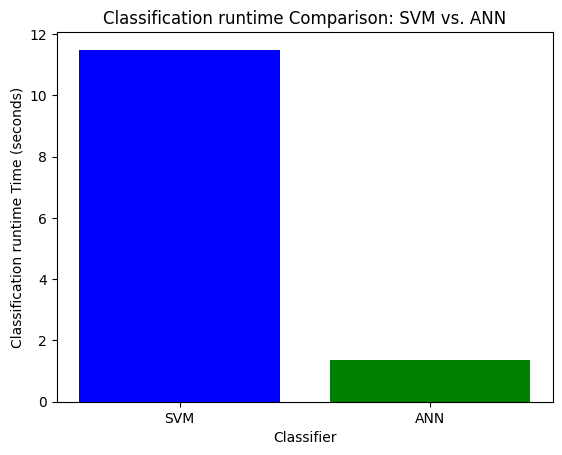

In [ ]:
pred_time_svm = 11.491287455102491
pred_time_ann = 1.370185375213623

classifiers = ['SVM', 'ANN']
training_times = [pred_time_svm, pred_time_ann]

plt.bar(classifiers, training_times, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('Classification runtime Time (seconds)')
plt.title('Classification runtime Comparison: SVM vs. ANN')
plt.show()

50/50 [==============================] - 0s 3ms/step
Overall Accuracy:  0.1311787072243346
50/50 [==============================] - 0s 3ms/step
Overall Accuracy:  0.12862547288776796
50/50 [==============================] - 0s 3ms/step
Overall Accuracy:  0.13801756587202008
50/50 [==============================] - 0s 2ms/step
Overall Accuracy:  0.148708254568368
52/52 [==============================] - 0s 3ms/step
Overall Accuracy:  0.15192190359975594
53/53 [==============================] - 0s 3ms/step
Overall Accuracy:  0.22505938242280285
48/48 [==============================] - 0s 4ms/step
Overall Accuracy:  0.3150955833882663
50/50 [==============================] - 0s 3ms/step
Overall Accuracy:  0.4012698412698413
49/49 [==============================] - 0s 2ms/step
Overall Accuracy:  0.5134443021766966
52/52 [==============================] - 0s 3ms/step
Overall Accuracy:  0.6024242424242424
50/50 [==============================] - 0s 3ms/step
Overall Accuracy:  0.6733542319749

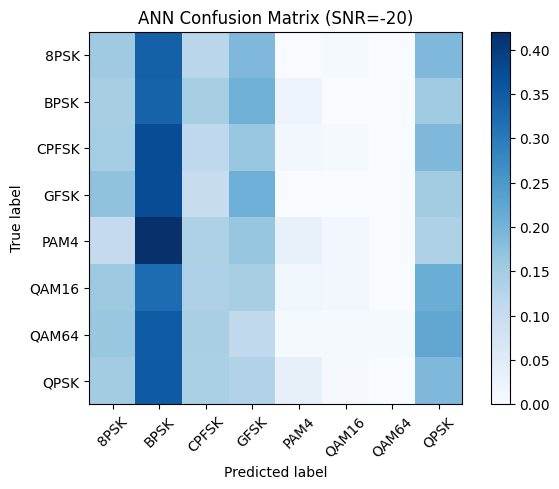

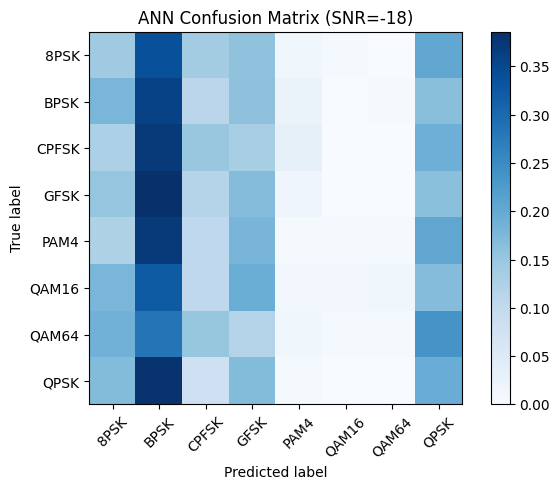

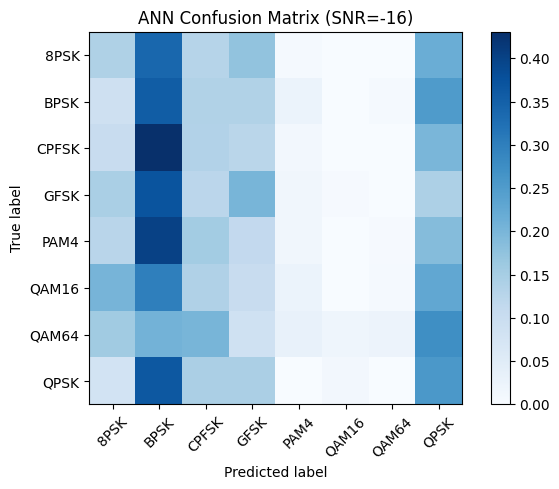

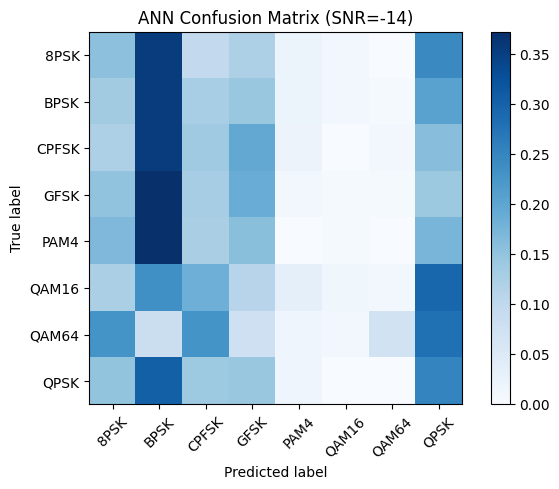

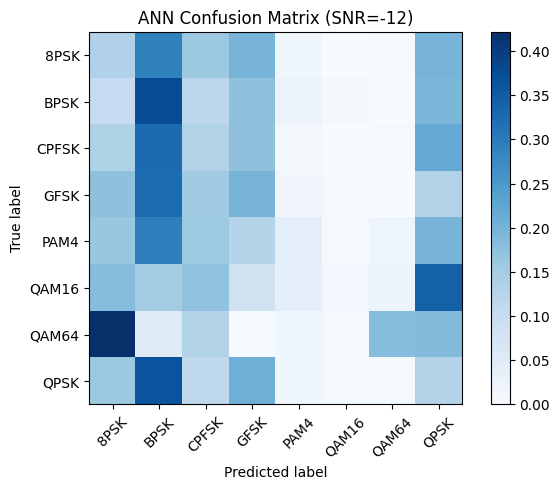

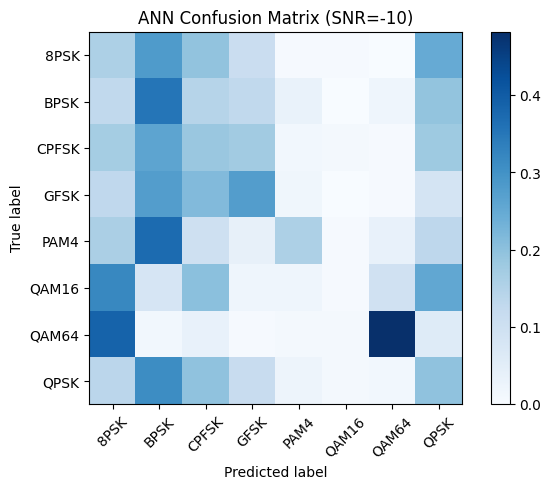

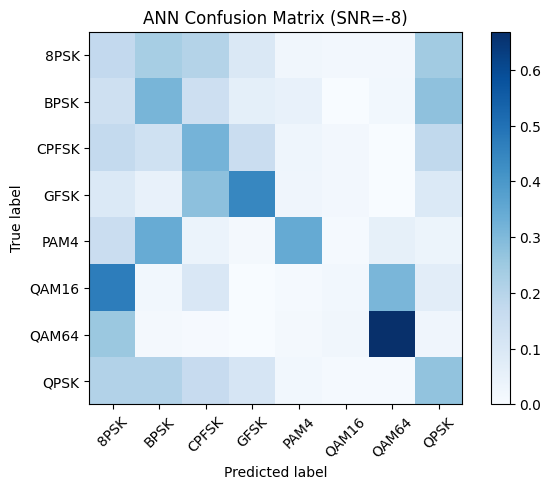

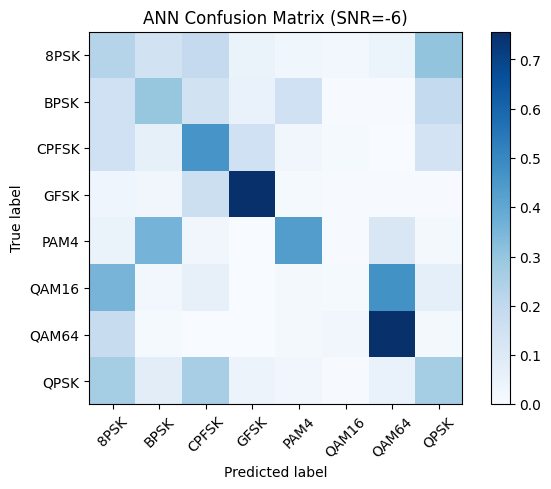

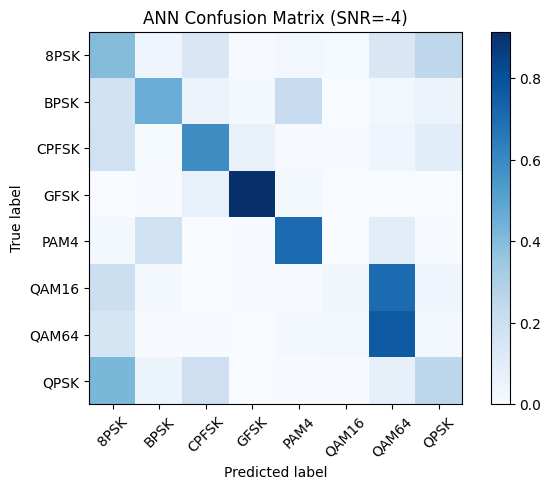

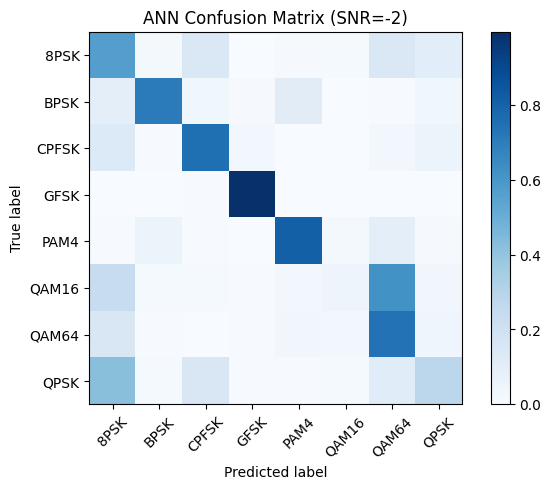

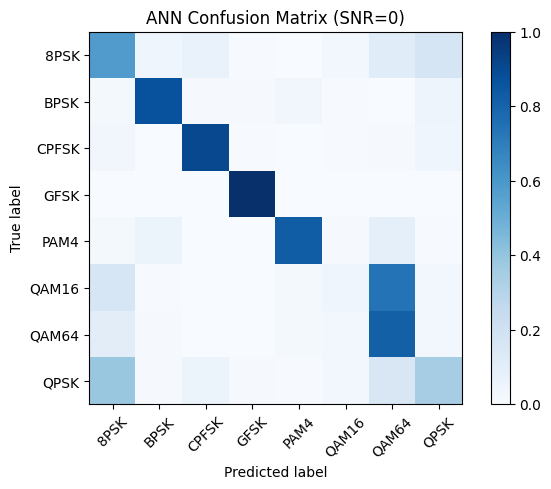

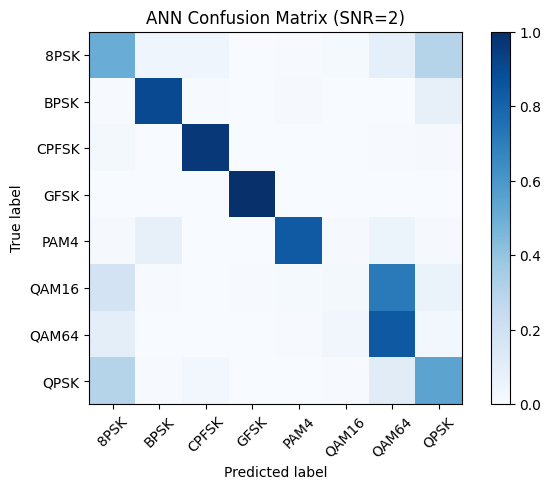

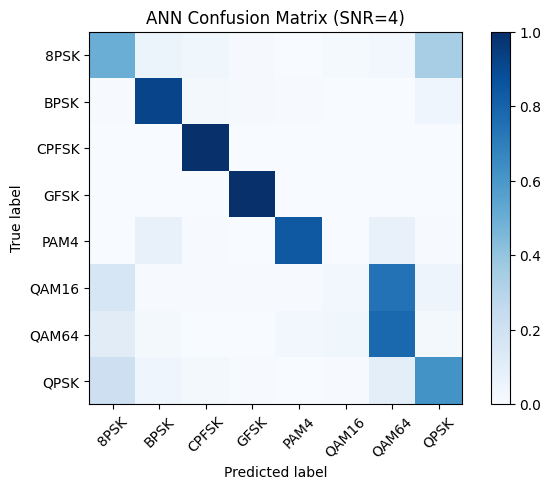

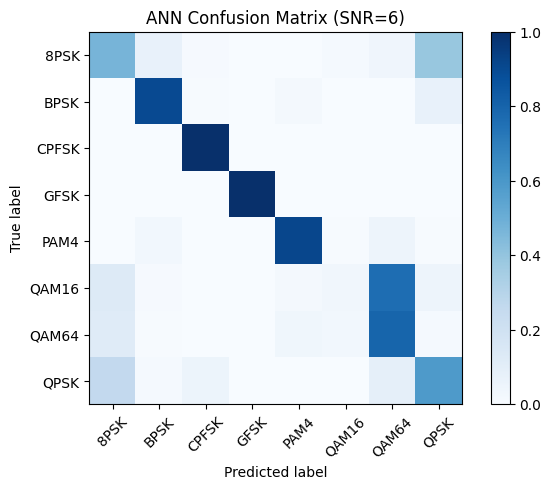

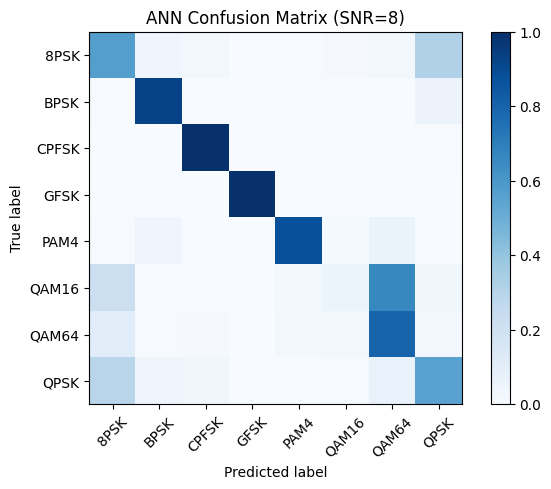

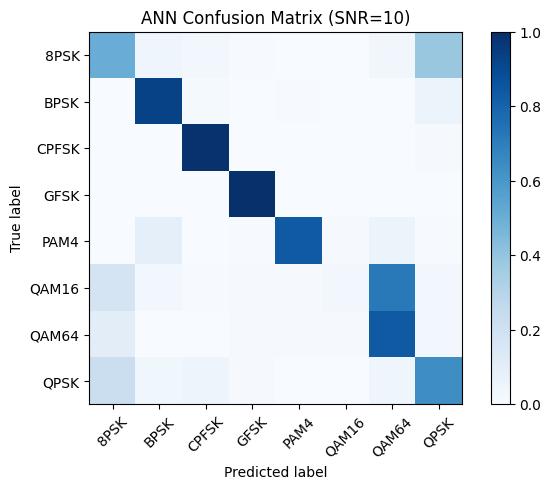

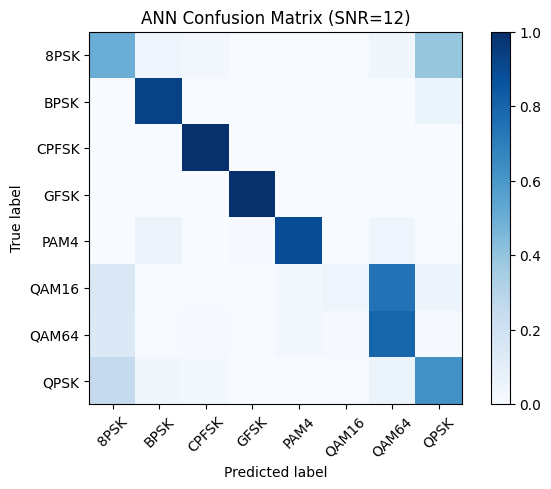

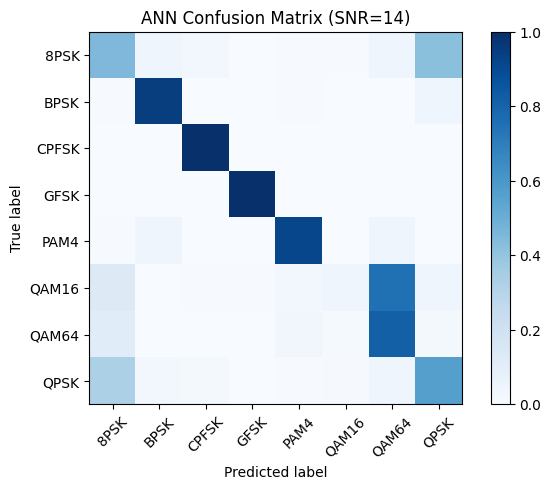

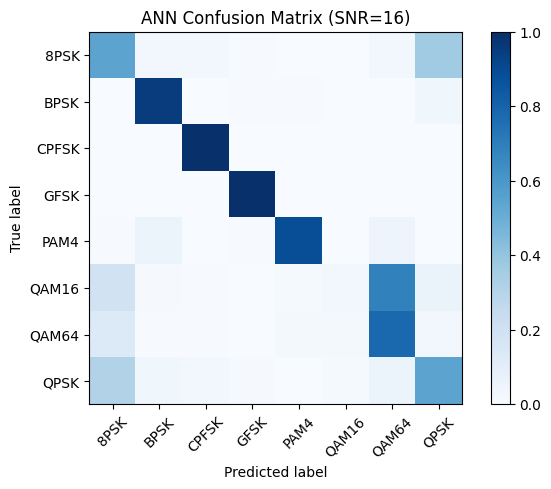

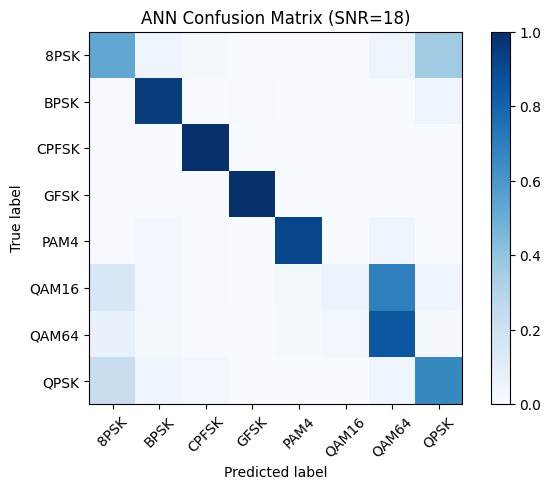

In [ ]:



# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ANN Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)

In [ ]:
# Save results to a pickle file for plotting later
print(acc)
result = open('ANN_results.pkl','wb')
pickle.dump( ("ANN", 0.5, acc) , result)

{-20: 0.1311787072243346, -18: 0.12862547288776796, -16: 0.13801756587202008, -14: 0.148708254568368, -12: 0.15192190359975594, -10: 0.22505938242280285, -8: 0.3150955833882663, -6: 0.4012698412698413, -4: 0.5134443021766966, -2: 0.6024242424242424, 0: 0.6733542319749216, 2: 0.6947300771208226, 4: 0.71625, 6: 0.7114427860696517, 8: 0.7264851485148515, 10: 0.7092288242730721, 12: 0.7313156269302038, 14: 0.7061376317420954, 16: 0.7163613392293114, 18: 0.7409420289855072}
